<a href="https://colab.research.google.com/github/wasnaqvi/Projects/blob/main/Exoplanetary_Atmospheres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **4.9.1**

Ya start by stealing this off Heng:

$$
\epsilon_2 \equiv \frac{K}{J}
= \frac{F_+}{2K_+}
= \frac{F_-}{2K_-}.
\tag{4.44}
$$

---

Rearrange that shit for $\epsilon_2$,

$$
\frac{F_+}{2K_+} = \frac{F_-}{2K_-}
\quad \Rightarrow \quad
F_- = \frac{K_-}{K_+}\,F_+ .
$$

In da longwave Eddington case,

$$
\frac{K_+}{J_+} = \frac{K_-}{J_-} = \epsilon_3 = \frac{1}{3}
\quad \Rightarrow \quad
K_+ = K_- .
$$

Subbing this  gives

$$
\boxed{F_- = \frac{F_+^2}{2K_-}}
\tag{4.45}
$$

which is exactly Eq. (4.45) in the text.

---

Then ya define the net flux and mean intensity:

$$
F = F_+ - F_- , \qquad
J = J_+ + J_- , \qquad
K = K_+ + K_- .
$$

And now, using the third Eddington coefficient,

$$
\epsilon_3 \equiv \frac{K}{J} = \frac{1}{3}
\quad \Rightarrow \quad
K = \frac{J}{3}.
$$

The two-stream approximation also gives

$$
F_\pm = 2\epsilon_2 K_\pm .
$$

Hence the net flux is

$$
F = 2\epsilon_2 (K_+ - K_-).
$$

Again, Using Heng's Eq. (4.45) together with $K_+ = K_-$ and $K = J/3$, we obtain

$$
\epsilon_L \equiv \frac{F}{J}
= \frac{\epsilon_2^2}{2\epsilon_3}.
$$

With $\epsilon_3 = 1/3$ and $\epsilon_2 = 1/2$,

$$
\boxed{
\epsilon_L = \frac{F}{J}
= \frac{\epsilon_2^2}{2\epsilon_3}
= \frac{3}{8}
}
\tag{4.46}
$$

And that is what we was asked to show
---


# 4.9.2



# 4.9.3


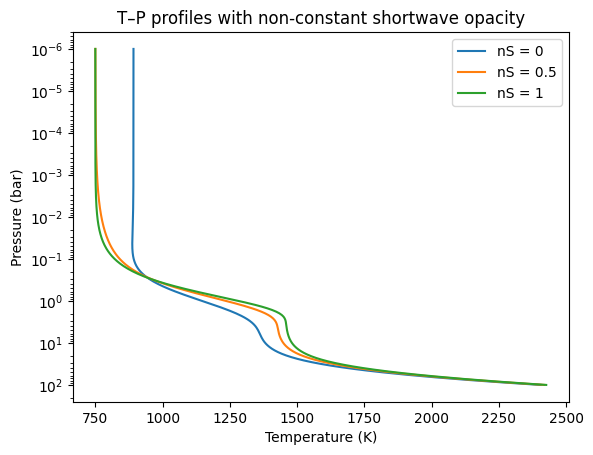

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expn  # expn(n, x) = E_n(x)


eps_L  = 1.0
eps_2  = 0.5
eps_3  = 1.0/3.0
eps_L3 = eps_L * eps_3  # ehhh need to read notes again?

beta_L0 = 1.0
beta_S0 = 1.0

# writing down the goddam units

g = 1e3  # cm/s^2
Tint = 200.0   # K
Tirr = 1500.0  # K

# Longwave opacity κ_L( m ) = κ0 + κ_CIA (m/m0). I need to be careful here lol
kappa0   = 1e-3   # cm^2/g....I think?
kappaCIA = 5e-3   # cm^2/g
m0 = 1e3          # g/cm^2

# Shortwave opacity κ_S(m) = κ_S0 (m/m0)^nS
kappaS0 = 1e-3  # cm^2/g
Pbar = np.logspace(-6, 2, 400)              # 1 microbar to 100 bar
Pdyn = Pbar * 1e6                           # 1 bar = 1e6 dyn/cm^2
m_grid = Pdyn / g                           # g/cm^2


def kappa_L(m):
    return kappa0 + kappaCIA * (m / m0)


def kappa_S(m, nS):
    # avoid m=0 issues
    return kappaS0 * (np.maximum(m, 1e-30) / m0) ** nS


def tau_S(m, nS):
    '''
    tau_S = ∫0^m κ_S dm
    '''
    return (kappaS0 * m0 / (nS + 1.0)) * (np.maximum(m, 1e-30) / m0) ** (nS + 1.0)


def T_profile(m_grid, nS):
    """
    Implements Eq. (4.39) with Q-term dropped (radiative equilibrium).
    We compute the needed integrals numerically on the m-grid.
    """
    m = m_grid

    kL = kappa_L(m)
    kS = kappa_S(m, nS)

    # First Integral(0^m κ_L dm (analytic for κ_L = κ0 + κCIA (m/m0))
    int_kL = kappa0 * m + kappaCIA * (m**2) / (2.0 * m0)

    betaS = tau_S(m, nS) / beta_S0
    E3 = expn(3, betaS)  # E_3(betaS)

    # Need I(m) = ∫0^m κ_L(m') E3(betaS(m')) dm'  (numerical cumulative integral)
    integrand = kL * E3
    I = np.zeros_like(m)
    I[1:] = np.cumsum(0.5 * (integrand[1:] + integrand[:-1]) * (m[1:] - m[:-1]))

    # Assemble Eq. (4.39) (global mean); Q-term omitted
    term_int = (Tint**4 / 4.0) * ( (1.0/eps_L) + (1.0/(eps_L3 * beta_L0**2)) * int_kL )

    term_irr = (Tirr**4 / 8.0) * (
        (1.0/(2.0*eps_L))
        + (kS * eps_2) / (kL * beta_S0)
        + (1.0/(eps_L3 * beta_L0**2)) * I
    )

    T4 = term_int + term_irr
    return T4**0.25

nS_list = [0.0, 0.5, 1.0]

plt.figure()
for nS in nS_list:
    T = T_profile(m_grid, nS)
    plt.semilogy(T, Pbar, label=f"nS = {nS:g}")

plt.gca().invert_yaxis()
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.legend()
plt.title("T–P profiles with non-constant shortwave opacity")
plt.show()


# Problem 3.8.3: Henyey-Greenstein scattering phase function

The Assignment, quite open-endedly I deign to notice, ask the question Does the Henyey-Greenstein phase function obey the normalization symmetry in (3.41)?
From Heng's book, I know:

$$\mathcal{P} = \frac{1 - g_0^2}{4\pi (1 + g_0^2 - 2g_0 \cos\theta'')^{3/2}}$$

$$\mu'' = \mu'\mu + (1-\mu'^2)^{1/2}(1-\mu^2)^{1/2}\cos(\phi' - \phi)$$

Symmetry requirement: $\mu'' \to \mu''$ when $\mu \to -\mu$ and $\mu' \to -\mu'$.

Is this variant??


To find out, I apply transformation $\mu \to -\mu$, $\mu' \to -\mu'$:

$$\mu''_{\text{new}} = (-\mu')(-\mu) + (1-(-\mu')^2)^{1/2}(1-(-\mu)^2)^{1/2}\cos(\phi' - \phi)$$

$$= \mu'\mu + (1-\mu'^2)^{1/2}(1-\mu^2)^{1/2}\cos(\phi' - \phi) = \mu''$$

Since $\mathcal{P}$ depends only on $\mu'' = \cos\theta''$, and $\mu''$ is invariant under the transformation:

$$\mathcal{P}(\mu \to -\mu, \mu' \to -\mu') = \mathcal{P}(\mu'')$$

The symmetry holds.

---

Now Imma check normalization.

Check $\int_0^{4\pi} \mathcal{P} \, d\Omega'' = 1$:

$$\int_0^{2\pi} d\phi'' \int_{-1}^{1} \frac{1 - g_0^2}{4\pi (1 + g_0^2 - 2g_0 \mu'')^{3/2}} \, d\mu''$$

Since $\mathcal{P}$ is $\phi''$-independent:

$$= 2\pi \cdot \frac{1-g_0^2}{4\pi} \int_{-1}^{1} \frac{d\mu''}{(1 + g_0^2 - 2g_0 \mu'')^{3/2}}$$

$$= \frac{1-g_0^2}{2} \int_{-1}^{1} (1 + g_0^2 - 2g_0 \mu'')^{-3/2} \, d\mu''$$

Substitute $u = 1 + g_0^2 - 2g_0\mu''$, so $du = -2g_0 \, d\mu''$:

Limits: $\mu'' = -1 \Rightarrow u = (1+g_0)^2$; $\mu'' = 1 \Rightarrow u = (1-g_0)^2$

$$= \frac{1-g_0^2}{2} \cdot \frac{1}{-2g_0} \int_{(1+g_0)^2}^{(1-g_0)^2} u^{-3/2} \, du$$

$$= -\frac{1-g_0^2}{4g_0} \left[ -2u^{-1/2} \right]_{(1+g_0)^2}^{(1-g_0)^2}$$

$$= \frac{1-g_0^2}{2g_0} \left[ u^{-1/2} \right]_{(1+g_0)^2}^{(1-g_0)^2}$$

$$= \frac{1-g_0^2}{2g_0} \left( \frac{1}{|1-g_0|} - \frac{1}{1+g_0} \right)$$

For $|g_0| < 1$:

$$= \frac{1-g_0^2}{2g_0} \left( \frac{1}{1-g_0} - \frac{1}{1+g_0} \right)$$

$$= \frac{1-g_0^2}{2g_0} \cdot \frac{(1+g_0) - (1-g_0)}{(1-g_0)(1+g_0)}$$

$$= \frac{1-g_0^2}{2g_0} \cdot \frac{2g_0}{1-g_0^2} = 1 \quad   \text{Yes it is normalized!!   }  \checkmark$$

---
In essence?

Yes. The Henyey-Greenstein function obeys the symmetry because $\mu''$ is invariant under $(\mu, \mu') \to (-\mu, -\mu')$, $\mathcal{P}$ depends only on $\mu''$.  Therefore $\mathcal{P}$ is invariant under the transformation.  Normalization also verified: $\int \mathcal{P} \, d\Omega'' = 1$

# 3.8.4

## Part (a):

Subbing $\omega_0 = 1 into Equation (3.28)$ for the love of pure scattering)
$$\frac{\partial F_+}{\partial \tau'} = (\gamma_a + \gamma_s) F_-, \quad \frac{\partial F_-}{\partial \tau'} = (\gamma_a - \gamma_s) F_+ - 2\gamma_B B$$

I know, from Eq (3.32):
$$F_+ = A_1 \zeta_+ e^{\alpha \tau'} + A_2 \zeta_- e^{-\alpha \tau'} + \pi B + \frac{\pi B'}{2}$$
$$F_- = A_1 \zeta_- e^{\alpha \tau'} + A_2 \zeta_+ e^{-\alpha \tau'} + \pi B - \frac{\pi B'}{2}$$

where $\alpha = \sqrt{(\gamma_a - \gamma_s)(\gamma_a + \gamma_s)}$ and $\zeta_\pm = \frac{1}{2}[1 \pm (1-\omega_0)^{1/2}]$.

 At $\omega_0 = 1$: $\gamma_a = 0$, so $\alpha = \sqrt{-\gamma_s^2} \to 0$ and $\zeta_\pm = \frac{1}{2}$.

In the limit $\alpha \to 0$, expand exponentials:
$$e^{\alpha \tau'} \approx 1 + \alpha\tau', \quad e^{-\alpha \tau'} \approx 1 - \alpha\tau'$$

Substituting:
$$F_+ \approx \frac{A_1}{2}(1 + \alpha\tau') + \frac{A_2}{2}(1 - \alpha\tau') + \pi B + \frac{\pi B'}{2}$$
$$F_- \approx \frac{A_1}{2}(1 + \alpha\tau') + \frac{A_2}{2}(1 - \alpha\tau') + \pi B - \frac{\pi B'}{2}$$

Simplify:
$$F_+ = \frac{A_1 + A_2}{2} + \frac{A_1 - A_2}{2}\alpha\tau' + \pi B + \frac{\pi B'}{2}$$
$$F_- = \frac{A_1 + A_2}{2} + \frac{A_1 - A_2}{2}\alpha\tau' + \pi B - \frac{\pi B'}{2}$$

Apply boundary conditions at $\tau'_1$ and $\tau'_2$. For two interfaces:
- At $\tau'_1$: $F_{+,1}, F_{-,1}$
- At $\tau'_2$: $F_{+,2}, F_{-,2}$

From the equations above at $\tau' = \tau'_1$:
$$F_{+,1} = \frac{A_1 + A_2}{2} + \frac{A_1 - A_2}{2}\alpha\tau'_1 + \pi B_1 + \frac{\pi B'_1}{2}$$
$$F_{-,2} = \frac{A_1 + A_2}{2} + \frac{A_1 - A_2}{2}\alpha\tau'_2 + \pi B_2 - \frac{\pi B'_2}{2}$$

Let $\Delta\tau = \tau'_2 - \tau'_1$. Subtracting:
$$F_{-,2} - F_{+,1} = \frac{A_1 - A_2}{2}\alpha\Delta\tau + (\pi B_2 - \pi B_1) - \frac{\pi B'_2}{2} - \frac{\pi B'_1}{2}$$

Similarly:
$$F_{+,2} - F_{-,1} = -\frac{A_1 - A_2}{2}\alpha\Delta\tau + (\pi B_2 - \pi B_1) + \frac{\pi B'_2}{2} + \frac{\pi B'_1}{2}$$

For isothermal slab ($B' \approx 0$, $B_1 = B_2$), these reduce to:
$$F_{-,2} - F_{+,1} = \frac{A_1 - A_2}{2}\alpha\Delta\tau$$
$$F_{+,2} - F_{-,1} = -\frac{A_1 - A_2}{2}\alpha\Delta\tau$$

Adding and subtracting, with $\alpha\Delta\tau = \gamma_s\Delta\tau$ (since $\gamma_a = 0$):
$$F_{+,1} = F_{+,2} - \frac{(F_{+,2} - F_{-,1})\gamma_s\Delta\tau}{2 + \gamma_s\Delta\tau}$$
$$F_{-,2} = F_{-,1} + \frac{(F_{+,2} - F_{-,1})\gamma_s\Delta\tau}{2 + \gamma_s\Delta\tau}$$

With $\gamma_s = \omega_0 = 1$ at limit and $\gamma_a + \gamma_s = \gamma_s$, this gives Eqn (3.79).

---

## Part (b): Transparent vs opaque slab

For the transparent case, ($\gamma_s \to 0$ or $\Delta\tau \to 0$):
$$F_{+,1} = F_{+,2} - \frac{0}{2} = F_{+,2}$$
$$F_{-,2} = F_{-,1} + \frac{0}{2} = F_{-,1}$$
No change in flux! So radiation just....passes through.

For the opaque case ($\gamma_s\Delta\tau \to \infty$):
$$F_{+,1} = F_{+,2} - \frac{(F_{+,2} - F_{-,1})\gamma_s\Delta\tau}{\gamma_s\Delta\tau} = F_{+,2} - (F_{+,2} - F_{-,1}) = F_{-,1}$$
$$F_{-,2} = F_{-,1} + (F_{+,2} - F_{-,1}) = F_{+,2}$$
Fluxes exchange!

---

## Part (c): Asymptote as $\omega_0 \to 1$

From (3.32) with $\alpha = \sqrt{(\gamma_a^2 - \gamma_s^2)}$ and $\gamma_a = 1 - \omega_0$, $\gamma_s = \omega_0$:
$$\alpha = \sqrt{(1-\omega_0)^2 - \omega_0^2} = \sqrt{1 - 2\omega_0}$$

As $\omega_0 \to 1$: $\alpha \to 0$.

The exponentials become:
$$e^{\pm\alpha\tau'} \to 1$$

So:
$$F_+ \to A_1\zeta_+ + A_2\zeta_- + \pi B + \frac{\pi B'}{2}$$
$$F_- \to A_1\zeta_- + A_2\zeta_+ + \pi B - \frac{\pi B'}{2}$$

With $\zeta_+ = \zeta_- = \frac{1}{2}$:
$$F_+ \to \frac{A_1 + A_2}{2} + \pi B + \frac{\pi B'}{2}$$
$$F_- \to \frac{A_1 + A_2}{2} + \pi B - \frac{\pi B'}{2}$$

Both fluxes become lose $\tau'$ dependence from exponentials as they approach diffusion limit.

The fluxes differ only by the Planck function gradient term, indicating slow diffusive transport without absorption.

# Problem 3.8.5: The diffusion approximation

## Part (a): Expression for $l_{\text{diff}}$

Fick's law in Heng os :
$$\mathcal{F} = -l_{\text{diff}} \frac{\partial}{\partial z} (\sigma_{\text{SB}} T^4)$$

From equation (3.69):
$$\mathcal{F} = -\frac{4\pi\epsilon_3}{\rho\kappa_R} \frac{\partial \mathcal{B}}{\partial z}$$

where ya known $\mathcal{B} = \frac{\sigma_{\text{SB}} T^4}{\pi}$ from (3.70).

Therefore:
$$\mathcal{F} = -\frac{4\pi\epsilon_3}{\rho\kappa_R} \frac{\partial}{\partial z}\left(\frac{\sigma_{\text{SB}} T^4}{\pi}\right) = -\frac{4\epsilon_3}{\rho\kappa_R} \frac{\partial}{\partial z}(\sigma_{\text{SB}} T^4)$$

Comparing with Fick's law:
$$l_{\text{diff}} = \frac{4\epsilon_3}{\rho\kappa_R}$$

From equation (3.67), we have $\epsilon_3 = 1/(4\pi)$ (for isotropic scattering). Actually, looking at the context more carefully, $\epsilon_3$ is related to the Eddington approximation. For the diffusion limit, we typically have $\epsilon_3 \approx 1/3$ based on the moments of intensity.

So:
$$l_{\text{diff}} = \frac{4 \cdot (1/3)}{\rho\kappa_R} = \frac{4}{3\rho\kappa_R}$$

Or using the optical depth gradient $d\tau = \rho\kappa_R dz$:
$$l_{\text{diff}} = \frac{4}{3\kappa_R\rho}$$

Now compute for hot Jupiter atmosphere:
- $\kappa_R = 0.01$ cm$^2$ g$^{-1}$
- $P = 100$ bar = $10^8$ dyne cm$^{-2}$
- $T = 1000$ K
- $m = 2m_H = 2 \times 1.67 \times 10^{-24}$ g

Ideal gas law: $P = \frac{\rho k_B T}{m}$, so:
$$\rho = \frac{Pm}{k_B T} = \frac{10^8 \times 2 \times 1.67 \times 10^{-24}}{1.38 \times 10^{-16} \times 1000}$$

$$\rho = \frac{3.34 \times 10^{-16}}{1.38 \times 10^{-13}} = 2.42 \times 10^{-3} \text{ g cm}^{-3}$$

Therefore:
$$l_{\text{diff}} = \frac{4}{3 \times 0.01 \times 2.42 \times 10^{-3}} = \frac{4}{7.26 \times 10^{-5}} = 5.51 \times 10^4 \text{ cm} = 550 \text{ m}$$

---

## Part (b): Ratio $H/l_{\text{diff}}$ ..... for hot Jupiter?

Pressure scale height:
$$H = \frac{k_B T}{mg} = \frac{1.38 \times 10^{-16} \times 1000}{2 \times 1.67 \times 10^{-24} \times 1000 \times 100}$$

$$H = \frac{1.38 \times 10^{-13}}{3.34 \times 10^{-19}} = 4.13 \times 10^5 \text{ cm} = 4.13 \text{ km}$$

Wait, let me recalculate. Given $g = 1000$ cm s$^{-2}$:
$$H = \frac{k_B T}{mg} = \frac{1.38 \times 10^{-16} \times 1000}{2 \times 1.67 \times 10^{-24} \times 1000}$$

$$H = \frac{1.38 \times 10^{-13}}{3.34 \times 10^{-21}} = 4.13 \times 10^7 \text{ cm} = 413 \text{ km}$$

Ratio:
$$\frac{H}{l_{\text{diff}}} = \frac{4.13 \times 10^7}{5.51 \times 10^4} = 750$$

Since $H \gg l_{\text{diff}}$, the diffusion approximation is **good** for this hot Jupiter atmosphere. Radiation diffuses over scales much smaller than the pressure scale height.

---

## Part (c): Earth's atmosphere (This should be 1. I know already)

For Earth: $P = 1$ bar = $10^6$ dyne cm$^{-2}$

Column mass: $\Sigma = P/g$. For Earth, $g = 980$ cm s$^{-2}$:
$$\Sigma = \frac{10^6}{980} = 1020 \text{ g cm}^{-2}$$

If typical infrared optical depth is $\tau_{\text{IR}} = 2$, and $\tau = \kappa_R \Sigma$:
$$\kappa_R = \frac{\tau_{\text{IR}}}{\Sigma} = \frac{2}{1020} = 1.96 \times 10^{-3} \text{ cm}^2 \text{ g}^{-1}$$

This is the Rosseland mean opacity.

Now compute density at surface (approximate using $T = 288$ K, $m = 29$ amu for air):
$$\rho = \frac{Pm}{k_B T} = \frac{10^6 \times 29 \times 1.67 \times 10^{-24}}{1.38 \times 10^{-16} \times 288}$$

$$\rho = \frac{4.84 \times 10^{-17}}{3.97 \times 10^{-14}} = 1.22 \times 10^{-3} \text{ g cm}^{-3}$$

Diffusion length:
$$l_{\text{diff}} = \frac{4}{3\kappa_R\rho} = \frac{4}{3 \times 1.96 \times 10^{-3} \times 1.22 \times 10^{-3}}$$

$$= \frac{4}{7.17 \times 10^{-6}} = 5.58 \times 10^5 \text{ cm} = 5.58 \text{ km}$$

Pressure scale height for Earth:
$$H = \frac{k_B T}{mg} = \frac{1.38 \times 10^{-16} \times 288}{29 \times 1.67 \times 10^{-24} \times 980}$$

$$= \frac{3.97 \times 10^{-14}}{4.74 \times 10^{-20}} = 8.38 \times 10^5 \text{ cm} = 8.4 \text{ km}$$

Ratio:
$$\frac{H}{l_{\text{diff}}} = \frac{8.4}{5.58} = 1.5$$

Eh. Close-ish.

Since $H \sim l_{\text{diff}}$, the diffusion approximation is flimsy af for Earth's atmosphere. The atmosphere is only moderately optically thick in the infrared, so diffusion theory is not as accurate as for the hot Jupiter.